<a href="https://colab.research.google.com/github/kvikik/MMO/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 5

##Задание: Парсинг новостных сайтов и построение баз статей.

Цель: Собрать корпуса новостных статей с русскоязычных сайтов, сохранить их в базах данных SQLite и променять умение работать с веб-парсингом, ограничениями сайтов и очисткой текста.

План работы:
1. Выбор источников и объёма
2. Проектирование структуры БД
3. Разработка парсера
4. Очистка и фильтрация текста
5. Учет ограничений сайтов
6. Запись в SQLite
7. Проверка результата и краткое описание

###1. Выбор источников и объёма



1. https://www.newsvl.ru/ — региональный новостной портал Владивостока и Приморья (локальные новости, городская повестка).​

2. https://lenta.ru/ — крупный общероссийский новостной сайт, общая повестка по России и миру.​

3. https://ria.ru/ — федеральное агентство новостей (политика, экономика, общество и т.п.).​

4. https://gamemag.ru/ — новости игр, кино и технологий.​​

5. https://stopgame.ru/news — отраслевой сайт про игры и игровые новости.​


| Сайт             | Тип          | Тематика / регион                          | Оценка статей за 3–6 месяцев |
| ---------------- | ------------ | ------------------------------------------ | ---------------------------- |
| newsvl.ru        | Региональный | Владивосток, Приморский край               | 500–1000                     |
| lenta.ru         | Федеральный  | Общероссийские и мировые новости           | 1500–2000                    |
| ria.ru           | Федеральный  | Новости России, регионы, справочные тексты | 1500–2000                    |
| gamemag.ru       | Отраслевой   | Игровая индустрия, кино, технологии        | 500–800                      |
| stopgame.ru/news | Отраслевой   | Игровые новости                            | 500–800                      |

###2. Проектирование структуры БД



####Шаг 1. Перечень полей и назначение

Список обязательных полей:
* guid — уникальный идентификатор записи (UUID v4), первичный ключ.​
* title — заголовок статьи.​
* description — очищенный текст статьи без HTML и медиа.​
* url — ссылка на статью.​
* published_at — дата/время публикации на сайте.​
* comments_count — число комментариев или NULL/0, если данных нет.​
* created_at_utc — время вставки записи в БД (UTC).​
* rating — лайки/оценка или NULL/0, если поле отсутствует.​

####Шаг 2. Выбор типов данных в SQLite

SQLite гибко относится к типам, но для читаемости и удобства работы удобно задать:

* guid как TEXT (строка с UUID, удобно дебажить и логировать).​
* title, description, url как TEXT.​
* published_at как TEXT в формате ISO (YYYY-MM-DDTHH:MM:SS) или INTEGER (Unix timestamp) — задание разрешает выбрать единообразный формат, часто используют ISO-строки.​
* comments_count, rating как INTEGER (с NULL по умолчанию).​
* created_at_utc как TEXT в ISO-формате (проще читать и логировать).​

####Шаг  3. SQL-схема таблицы

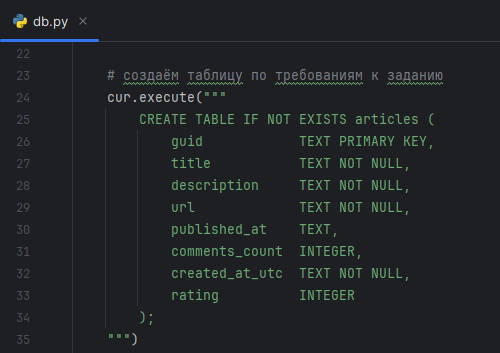

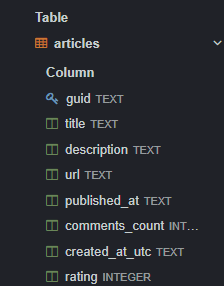

####Шаг 4. Ограничения и индексы

Дополнительно можно:

* добавить уникальный индекс по url, чтобы не вставлять одну и ту же статью дважды;​
* создать индекс по published_at для быстрых выборок по периоду.

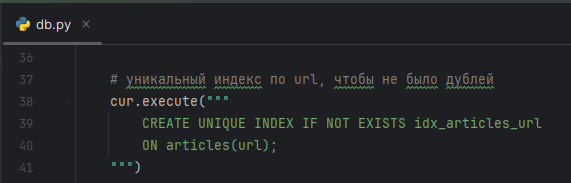

Это улучшит производительность запросов анализа.

###3. Разработка парсера



####Шаг 1. Общая архитектура и модули

Структура:

* config.py — список сайтов, настройки rate limit, заголовки.​

* db.py — функции работы с SQLite (init_db, save_article).​

* fetcher.py — функции скачивания HTML / JSON (с rate limit, User-Agent, retry).​

* cleaner.py — очистка HTML и текста.​
* parsers/
  * newsvl.py
  * lenta.py
  * ria.py
  * gamemag.py
  * stopgame.py — в каждом модуле: логика поиска ссылок и разбор конкретной разметки.​
* run_scraping.py — точка входа: выбирает сайты, запускает парсинг и сохранение в БД.​


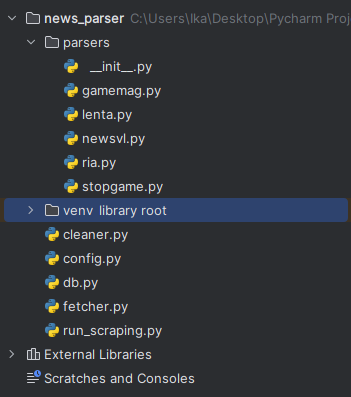

####Шаг 2. Поток работы парсера

Общий план для каждого сайта:

1. Получить HTML страницы/страниц ленты новостей (архив, раздел «Все новости»).​
2. Извлечь список ссылок на статьи (селекторы по < a>, блокам новостей).​
3. Для каждой ссылки: скачать страницу статьи с учётом ограничений (задержки, User-Agent, retry).​
4. Извлечь из HTML: заголовок, дату, тело статьи, число комментариев/рейтинг.​
5. Очистить текст от HTML/медиа (через cleaner.py).​
6. Отфильтровать слишком короткие или состоящие почти полностью из медиа статьи.​
7. Сформировать запись и сохранить её через db.save_article(...).

####Шаг  3. Базовые функции: загрузка и очистка

Суть базовых функций (в стиле псевдокода):
* В fetcher.py:
  * fetch_html(url) — requests либо aiohttp, настройки заголовков, таймаут, retry, ограничение параллелизма.​
* В cleaner.py:
  * clean_html(html_or_node) — удаляет script, style, video, audio, img, figure и т.п., возвращает чистый текст с переносами строк.​

Эти функции переиспользуются всеми парсерами сайтов, чтобы не дублировать код.

####Шаг   4. Логика для каждого сайта

Для каждого из источников нужен свой модуль с примерно таким набором функций:​

* get_article_links() — парсит ленту/архив и возвращает список URL статей.
* parse_article(url) — для одной статьи:
  * скачивает HTML;
  * достаёт заголовок, дату, текстовый блок, счётчики комментариев/лайков (если есть);
  * очищает текст;
  * возвращает структуру данных (словарь) либо сразу вызывает save_article.


####Шаг   5. Учет ограничений (rate limit, User-Agent, retry)

В парсер нужно встроить:

* Ограничение частоты запросов:
  * для простоты — задержка sleep между запросами;
  * для ускорения — асинхронный подход с asyncio.Semaphore(max_concurrent) и aiohttp.​
* Несколько вариантов User-Agent и случайный выбор при запросе.​
  * Обработку ошибок:
  * перехват HTTP-ошибок;
  * несколько попыток с экспоненциальной задержкой;
  * логирование неудачных URL, чтобы не терять информацию.

##Ход работы

Начнем с db.py:
* Даты (published_at, created_at_utc) хранятся как TEXT в ISO‑формате, что удобно для чтения и сортировки.​
* guid генерируется через UUID v4 и хранится как строка.
* INSERT OR IGNORE защищает от дубликатов по полю url (из‑за уникального индекса)

Проверка на работоспособность

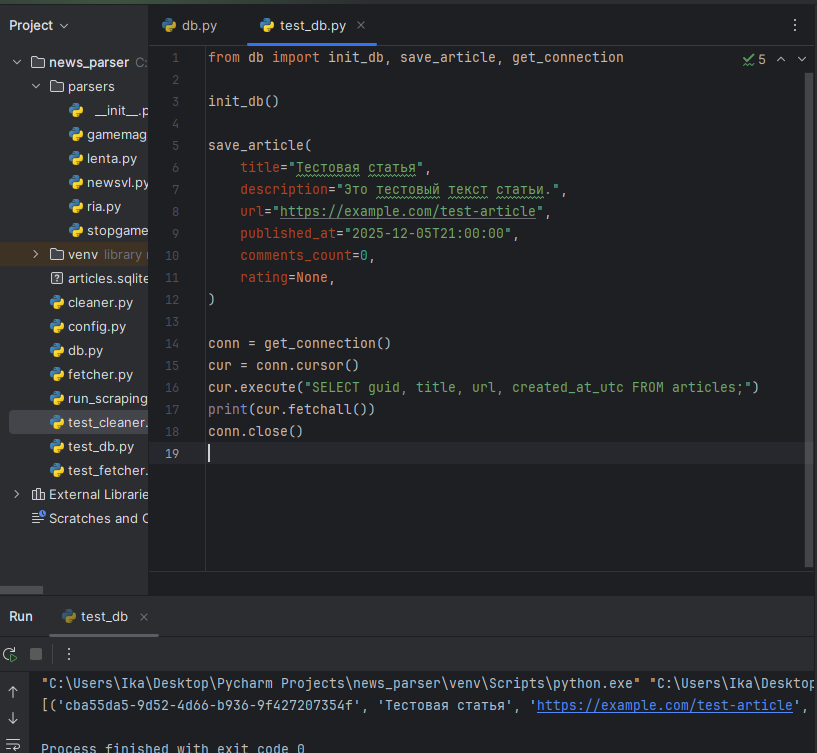

Далее fetcher.py реализует
* смену User-Agent, чтобы не светиться стандартной строкой python-requests/...;
* задержки между запросами (rate limit), чтобы не спамить сайты;
* повтор запросов при временных HTTP‑ошибках и сетевых проблемах


Проверка на работоспособность

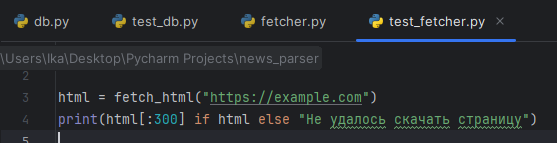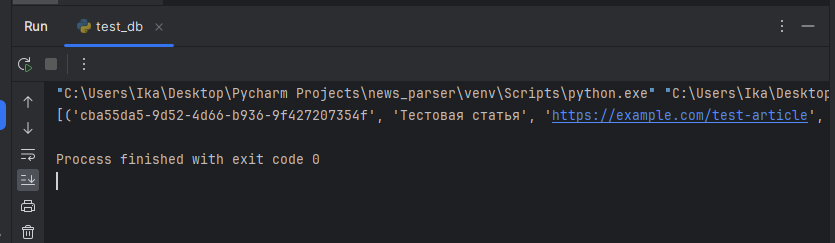

Далее cleaner.py превращает HTML в чистый текст для поля description и отбрасывает слишком короткие статьи
* удаляет script, style, img, video и другие медиа/служебные теги через decompose(), как рекомендуют примеры с BeautifulSoup;​

* использует get_text(separator="\n"), чтобы сохранить структурные переносы строк;

* фильтрует заведомо короткие тексты (по умолчанию установили порог 200 символов).


Проверка на работоспособность

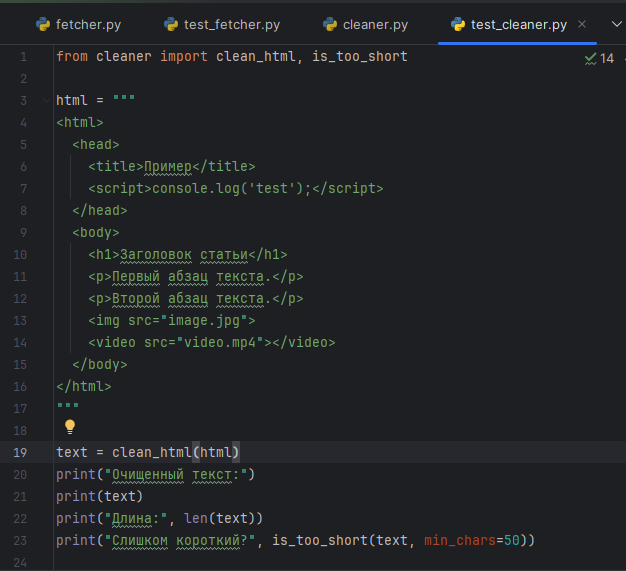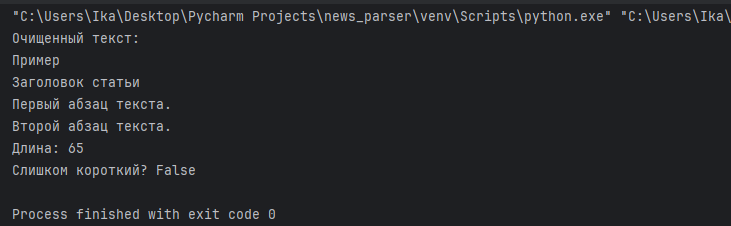

###Переходим полноценнок к парсингу сайтов

Начнём с newsvl.ru

Шаг 1. Идея парсера для NewsVL
Для начала сделаем простую версию:

* возьмём несколько дней архива (например, текущий и пару предыдущих);​

* со страниц архива соберём ссылки на все новости;​

* для каждой новости заберём страницу, вытащим заголовок, дату и текст, очистим и сохраним в БД.​

Шаг 2. Код в parsers/newsvl.py

* def build_archive_urls - Формирует список URL архивов за последние days_back дней, включая сегодня
* def get_article_links_from_archive -  Получает HTML страницы архива и достаёт ссылки на статьи/ Вернёт список полных URL.
*  def parse_article - Скачивает страницу статьи, вытаскивает заголовок, дату и текст,  очищает и сохраняет в БД.
* def run - Запускает парсинг NewsVL за несколько последних дней

Шаг 3. Подключаем парсер в run_scraping.py

Шаг 4. Пробный запуск только NewsVL

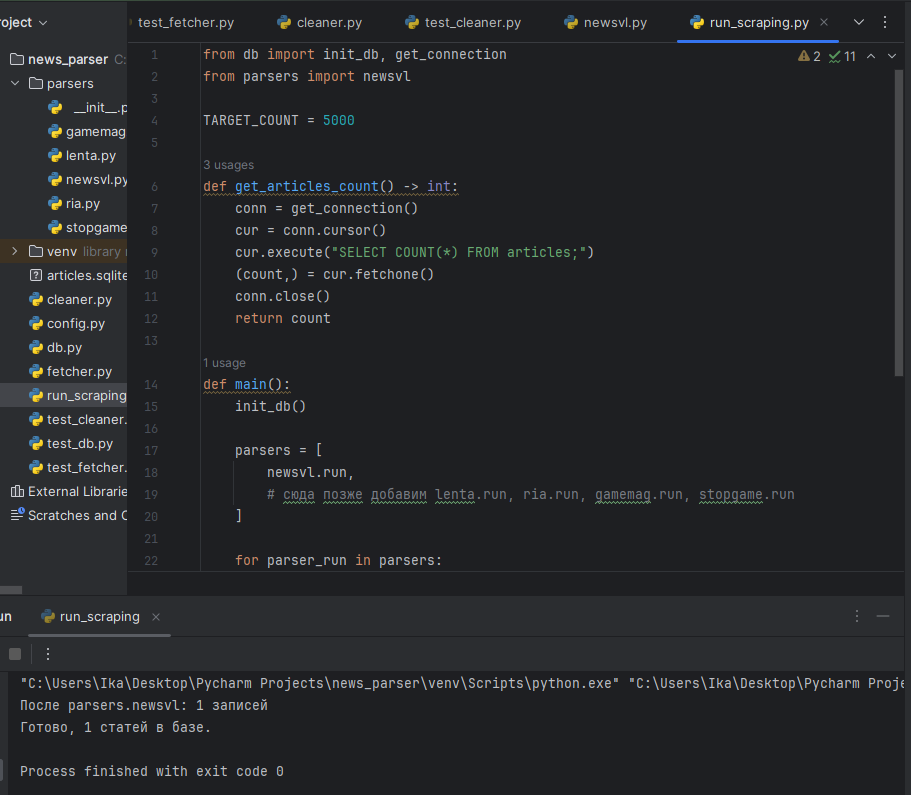

Скриншот показывает, что run_scraping.py отработал успешно: после parsers.newsvl в базе 1 статья, ошибок нет. Но сейчас в базе лежит только тестовая статья, которую создавали через test_db.py
* Удалили тестовый файл articles.sqlite, чтобы туда уже записывались нужные нум данные с сайта.
* В результате выяснилось, что парсер newsvl.run() отработал, но не нашёл ни одной статьи — значит, проблема в селекторах или датах, также возможна проблема в "фильтре", а то есть ограничении по длине статьи.
* Временно убрали фильтр по длине, и упростим поиск ссылок(упрощение в том, что вместо сложных CSS‑классов мы берём все ссылки определённого вида по регулярному выражению, не завися от верстки), увеличили глубину ( за сколько дней искали новости)
* И снова пусто(

Сделаем проверку. Проверим, что get_article_links_from_archive вообще что‑то находит.
* Вспомогательная функция для отладки: печатает, сколько ссылок нашлось в архиве за сегодня и несколько примеров.

И в отдельном файле debug_newsvl.py:

```
from parsers import newsvl
newsvl.debug_archive()
```
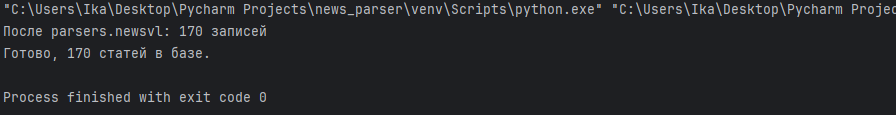

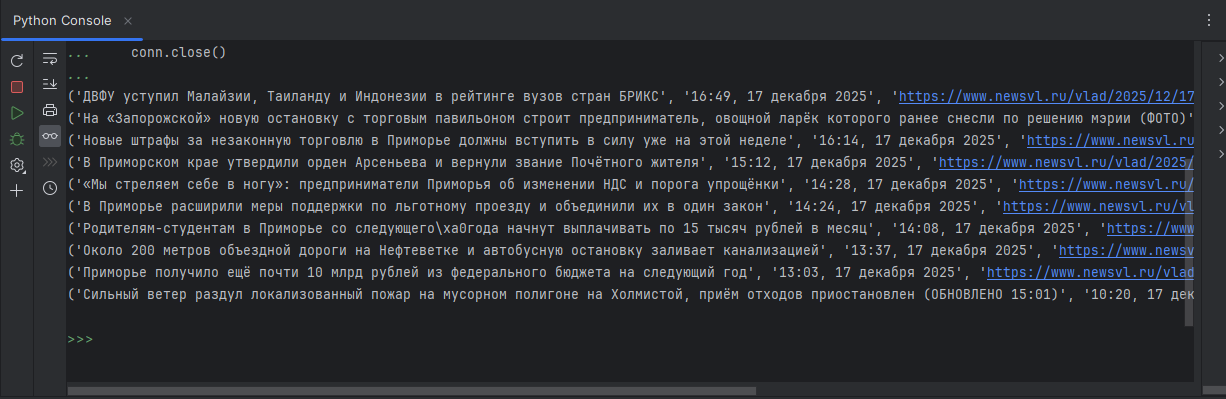

Меняем план. Упрощаем и оставляем один сайт.
Берем Lenta.ru. У Lenta.ru десятки тысяч новостей в год, есть архив по датам и готовые RSS‑ленты (/rss/news, /rss/news/russia, /rss/news/world и т.д.), которые сильно упрощают парсинг.


* Оставляем всю инфраструктуру: db.py, fetcher.py, cleaner.py, run_scraping.py.

* Модуль parsers/newsvl.py просто не подключаем в run_scraping.py.

* Создаём новый модуль parsers/lenta.py, который:
  * ходит по архиву дат, например /2024/01/01/, /2024/01/02/ и т.д.;
  * или использует RSS /rss/news и разбирает ссылки на статьи;
  * по каждой статье скачивает страницу, вытаскивает заголовок, дату, основной текст, очищает и сохраняет в БД.
